# RETO DE ANALÍTICA E INTELIGENCIA ARTIFICIAL PARA BIOCIENCIAS
Reto 1.	Clasificación del tipo de tumor: Empleando únicamente los datos de las imágenes de MRI, deberá entrenar un modelo que permita clasificar las imágenes en una de las tres categorías de tumor.
- Autor: Valery Castañeda


## Librerias

In [1]:
import os
import matplotlib.pyplot as plt
import random

import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization

2025-06-04 21:42:22.861569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)

2.12.0


## Carga de datos

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory='data/archive/Brain_Cancer raw MRI data/Brain_Cancer',
    labels='inferred',               # Detecta etiquetas por nombre de carpeta
    label_mode='categorical',                # 'int', 'categorical', o 'binary'
    image_size=(128, 128),           # Redimensiona imágenes automáticamente
    batch_size=32,
    shuffle=True
)

Found 6056 files belonging to 3 classes.


2025-06-04 21:42:37.124427: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-04 21:42:37.124800: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-04 21:42:37.124840: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-04 21:42:37.125468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-04 21:42:37.126207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Análisis exploratorio del dataset de imagenes

### Distribución de las imágenes por categoría

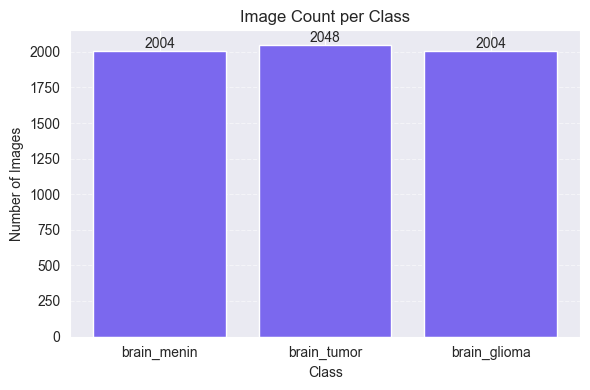

In [4]:
class_names = []
image_counts = []
path = 'data/archive/Brain_Cancer raw MRI data/Brain_Cancer'

for class_folder in os.listdir(path):
    class_path = os.path.join(path, class_folder)
    if os.path.isdir(class_path):
        class_names.append(class_folder)
        image_counts.append(len(os.listdir(class_path)))

plt.figure(figsize=(6, 4))
bars = plt.bar(class_names, image_counts, color='mediumslateblue')
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Añadir número encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2,  # Ajusta +2 si es necesario
             str(height), ha='center', va='bottom', fontsize=10)
plt.show()

### Visualización de las imagenes de manera aleatoria

2025-06-04 21:42:43.097839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6056]
	 [[{{node Placeholder/_4}}]]
2025-06-04 21:42:43.098399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6056]
	 [[{{node Placeholder/_4}}]]


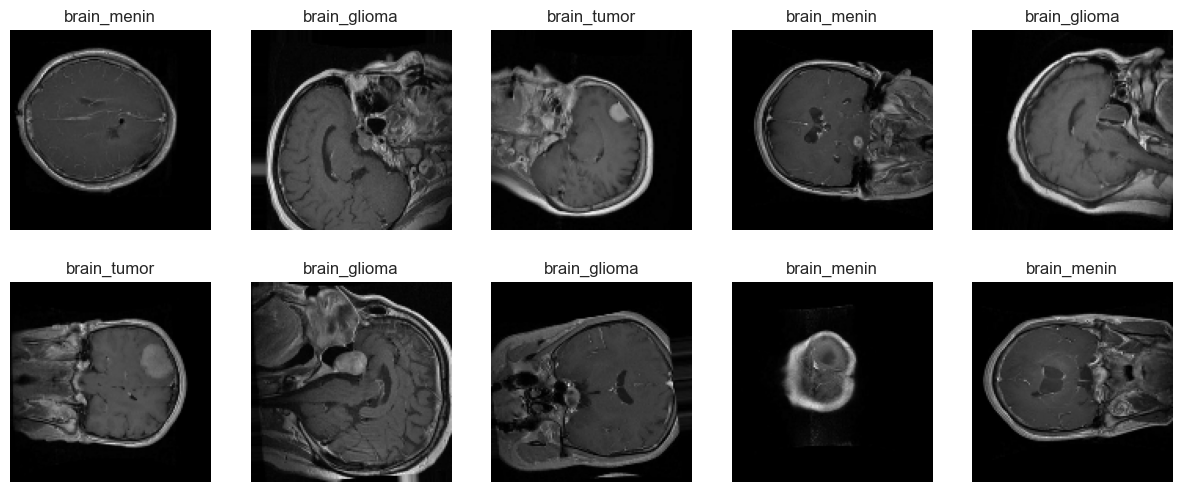

In [5]:
# Tomar un batch aleatorio
for images, labels in dataset.take(1):
    plt.figure(figsize=(15, 6))
    indices = random.sample(range(len(images)), 10)
    for i, idx in enumerate(indices):
        img = images[idx].numpy().astype("uint8")
        label = labels[idx].numpy()

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        class_index = np.argmax(label)
        plt.title(class_names[class_index])
        plt.axis("off")
    plt.show()

## Modelo para clasificar imagenes

### Preparación del dataset

In [33]:
# 1. Cargar dataset desde carpetas
dataset = tf.keras.utils.image_dataset_from_directory(
    directory='data/archive/Brain_Cancer raw MRI data/Brain_Cancer',
    labels='inferred',
    label_mode='categorical',
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

# 2. Convertir todo el tf.data.Dataset en arrays NumPy
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

x_data, y_data = dataset_to_numpy(dataset)

print("Total images:", x_data.shape)
print("Total labels:", y_data.shape)

# 3. Dividir manualmente en train/test (80% train, 20% test)
num_samples = x_data.shape[0]

test_size = int(num_samples * 0.15)
valid_size = int(num_samples * 0.15)
train_size = num_samples - test_size - valid_size

# Mezclar índices
indices = np.arange(num_samples)
np.random.seed(42)
np.random.shuffle(indices)

# Cortar índices para cada conjunto
test_indices = indices[:test_size]
valid_indices = indices[test_size:test_size + valid_size]
train_indices = indices[test_size + valid_size:]

# Crear splits
x_train, y_train = x_data[train_indices], y_data[train_indices]
x_valid, y_valid = x_data[valid_indices], y_data[valid_indices]
x_test, y_test = x_data[test_indices], y_data[test_indices]


print("Train images:", x_train.shape)
print("Validation images:", x_valid.shape)
print("Test images:", x_test.shape)



Found 6056 files belonging to 3 classes.


2025-06-04 22:52:50.403594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6056]
	 [[{{node Placeholder/_4}}]]
2025-06-04 22:52:50.404213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6056]
	 [[{{node Placeholder/_4}}]]


Total images: (6056, 128, 128, 3)
Total labels: (6056, 3)
Train images: (4240, 128, 128, 3)
Validation images: (908, 128, 128, 3)
Test images: (908, 128, 128, 3)


### Mapeo de categorías

In [8]:
num_classes = y_train.shape[1]

In [9]:
base_filtros = 32
w_regulatizer = 1e-4

### Arquitectura inicial de la red convolucional

In [34]:
model = Sequential()
## Conv 1
model.add(Conv2D(base_filtros, (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regulatizer), input_shape = x_train.shape[1:]))
model.add(Activation('relu'))

## Conv 2
model.add(Conv2D(base_filtros, (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

## Conv 3
model.add(Conv2D(2*base_filtros, (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

## Conv 4
model.add(Conv2D(2*base_filtros, (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

## Conv 5
model.add(Conv2D(4*base_filtros, (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))

## Conv 6
model.add(Conv2D(4*base_filtros, (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

## Classification - Flatten
model.add(Flatten())
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 activation_9 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 activation_10 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 32)        0         
                                                      

### Compilación del modelo

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

### Entrenamiento del modelo

In [12]:
hist = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data= (x_valid, y_valid),
                 verbose=2, shuffle=True)

Epoch 1/100


2025-06-04 21:43:40.287845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-04 21:43:54.678668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


133/133 - 17s - loss: 1.5089 - accuracy: 0.5557 - val_loss: 0.8575 - val_accuracy: 0.6421 - 17s/epoch - 127ms/step
Epoch 2/100
133/133 - 13s - loss: 0.7598 - accuracy: 0.6927 - val_loss: 0.6335 - val_accuracy: 0.7643 - 13s/epoch - 97ms/step
Epoch 3/100
133/133 - 13s - loss: 0.6406 - accuracy: 0.7491 - val_loss: 0.5646 - val_accuracy: 0.7985 - 13s/epoch - 94ms/step
Epoch 4/100
133/133 - 13s - loss: 0.5617 - accuracy: 0.7887 - val_loss: 0.5652 - val_accuracy: 0.7952 - 13s/epoch - 94ms/step
Epoch 5/100
133/133 - 13s - loss: 0.5130 - accuracy: 0.8047 - val_loss: 0.5300 - val_accuracy: 0.7996 - 13s/epoch - 95ms/step
Epoch 6/100
133/133 - 12s - loss: 0.4466 - accuracy: 0.8370 - val_loss: 0.4270 - val_accuracy: 0.8458 - 12s/epoch - 93ms/step
Epoch 7/100
133/133 - 13s - loss: 0.4172 - accuracy: 0.8505 - val_loss: 0.3815 - val_accuracy: 0.8711 - 13s/epoch - 96ms/step
Epoch 8/100
133/133 - 13s - loss: 0.3682 - accuracy: 0.8729 - val_loss: 0.4865 - val_accuracy: 0.8117 - 13s/epoch - 95ms/step
Epo

### Resultados del comportamiento del modelo

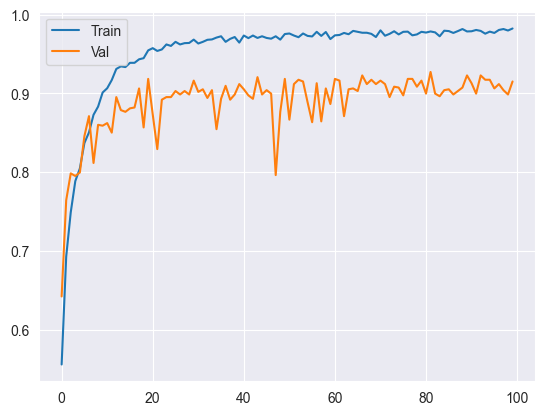

In [13]:
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Val')
plt.legend()

plt.show()

In [14]:
model.evaluate(x_test, y_test)

29/29 [==============================] - 2s 52ms/step - loss: 1.2690 - accuracy: 0.9086


[1.2690447568893433, 0.9085903167724609]

In [15]:
score= model.evaluate(x_test, y_test)

29/29 [==============================] - 2s 49ms/step - loss: 1.2690 - accuracy: 0.9086


### Conclusiones iniciales

*Con esto resultados se evidencia que el modelo esta presentado overfitting, dado que el modelo se ajusto demasiado a los datos de entrenamiento (pérdida baja y alta precisión) y no generaliza tan bien los datos nuevos (pérdida alta y precisión menor)*

### Refinamiento 1 del modelo inclusion de callbacks
Se incluye early para detener el modelo automaticamente si el accuracy o precision del entrenamiento deja de mejorar durante 3 epocas, por ello el modelo se detiene en la epoca 6


In [17]:
early = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
model.fit(x_train, y_train,
          batch_size=32,
          epochs=100, 
          callbacks=[early],
          validation_data= (x_valid, y_valid),
          verbose=2, shuffle=True)

Epoch 1/100


2025-06-04 22:05:54.074624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-04 22:06:07.998903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


133/133 - 17s - loss: 0.2630 - accuracy: 0.9764 - val_loss: 1.6718 - val_accuracy: 0.9009 - 17s/epoch - 126ms/step
Epoch 2/100
133/133 - 13s - loss: 0.2743 - accuracy: 0.9776 - val_loss: 1.3027 - val_accuracy: 0.8855 - 13s/epoch - 96ms/step
Epoch 3/100
133/133 - 13s - loss: 0.1999 - accuracy: 0.9840 - val_loss: 1.4771 - val_accuracy: 0.8954 - 13s/epoch - 95ms/step
Epoch 4/100
133/133 - 12s - loss: 0.2577 - accuracy: 0.9783 - val_loss: 0.9848 - val_accuracy: 0.9185 - 12s/epoch - 92ms/step
Epoch 5/100
133/133 - 13s - loss: 0.2168 - accuracy: 0.9802 - val_loss: 1.4245 - val_accuracy: 0.9130 - 13s/epoch - 95ms/step
Epoch 6/100
133/133 - 12s - loss: 0.2256 - accuracy: 0.9837 - val_loss: 1.6584 - val_accuracy: 0.9020 - 12s/epoch - 94ms/step


*Aqui estoy monitoreando el desempeño en validación no en entrenamiento*

In [41]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True )
hist2 = model.fit(x_train, y_train,
          batch_size=32,
          epochs=100, 
          callbacks=[early],
          validation_data= (x_valid, y_valid),
          verbose=2, shuffle=True)

Epoch 1/100


2025-06-04 22:57:57.941332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-04 22:58:12.173261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


133/133 - 16s - loss: 0.3601 - accuracy: 0.8821 - val_loss: 0.5665 - val_accuracy: 0.8161 - 16s/epoch - 122ms/step
Epoch 2/100
133/133 - 12s - loss: 0.3091 - accuracy: 0.8922 - val_loss: 0.4055 - val_accuracy: 0.8579 - 12s/epoch - 87ms/step
Epoch 3/100
133/133 - 12s - loss: 0.2888 - accuracy: 0.9073 - val_loss: 0.4502 - val_accuracy: 0.8348 - 12s/epoch - 87ms/step
Epoch 4/100
133/133 - 12s - loss: 0.2892 - accuracy: 0.9059 - val_loss: 0.3350 - val_accuracy: 0.8965 - 12s/epoch - 87ms/step
Epoch 5/100
133/133 - 12s - loss: 0.2447 - accuracy: 0.9255 - val_loss: 0.3212 - val_accuracy: 0.8877 - 12s/epoch - 88ms/step
Epoch 6/100
133/133 - 11s - loss: 0.2380 - accuracy: 0.9264 - val_loss: 0.3798 - val_accuracy: 0.8634 - 11s/epoch - 86ms/step
Epoch 7/100
133/133 - 12s - loss: 0.2185 - accuracy: 0.9363 - val_loss: 0.4969 - val_accuracy: 0.8502 - 12s/epoch - 87ms/step
Epoch 8/100
133/133 - 11s - loss: 0.2221 - accuracy: 0.9335 - val_loss: 0.2879 - val_accuracy: 0.8987 - 11s/epoch - 86ms/step
Epo

In [42]:
model.evaluate(x_test, y_test)

29/29 [==============================] - 2s 50ms/step - loss: 0.2841 - accuracy: 0.9064


[0.28412288427352905, 0.9063876867294312]

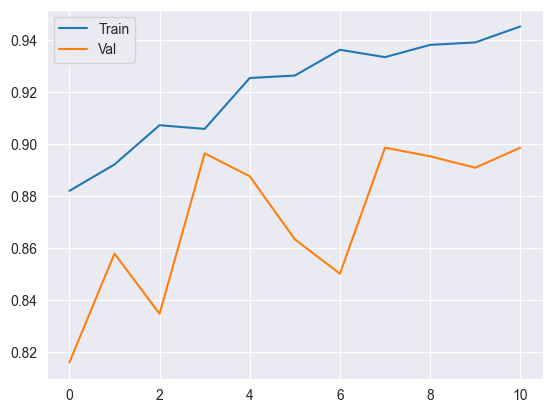

In [43]:
plt.plot(hist2.history['accuracy'], label='Train')
plt.plot(hist2.history['val_accuracy'], label='Val')
plt.legend()

plt.show()

### Refinamiento 2 Implementación de checkpoint monitoreando val_loss

* Aqui estoy guardando el mejor modelo durante el entrenamiento monitoreando val_loss dado que es mas sensible a errores pequeños, permite ver mas claro la equivocacion del modelo *

In [46]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='Checkpoint_Brain_Cancer.hdf5', 
                                   verbose = 1,
                                   monitor='val_loss',
                                   save_best_only=True)

hist3 = model.fit(x_train, y_train,
          batch_size=32,
          epochs=100, 
          callbacks=[checkpoint],
          validation_data= (x_valid, y_valid),
          verbose=2, shuffle=True)

Epoch 1/100


2025-06-04 23:04:08.477034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-04 23:04:20.991004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.37599, saving model to Checkpoint_Brain_Cancer.hdf5
133/133 - 15s - loss: 0.2363 - accuracy: 0.9349 - val_loss: 0.3760 - val_accuracy: 0.8767 - 15s/epoch - 112ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.37599 to 0.31035, saving model to Checkpoint_Brain_Cancer.hdf5
133/133 - 12s - loss: 0.2212 - accuracy: 0.9384 - val_loss: 0.3103 - val_accuracy: 0.8976 - 12s/epoch - 87ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.31035
133/133 - 11s - loss: 0.1983 - accuracy: 0.9521 - val_loss: 0.5663 - val_accuracy: 0.8535 - 11s/epoch - 86ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.31035
133/133 - 11s - loss: 0.1783 - accuracy: 0.9517 - val_loss: 0.3189 - val_accuracy: 0.9097 - 11s/epoch - 86ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.31035
133/133 - 13s - loss: 0.1958 - accuracy: 0.9505 - val_loss: 0.4096 - val_accuracy: 0.8921 - 13s/epoch - 94ms/step
Epoch 6/100

Epoch 6: val_loss did not improv

In [47]:
model2 = model
model2.load_weights('../models/Checkpoint_Brain_Cancer.hdf5')

In [48]:
model2.evaluate(x_test, y_test)

29/29 [==============================] - 2s 51ms/step - loss: 0.3234 - accuracy: 0.9119


[0.32337579131126404, 0.9118942618370056]

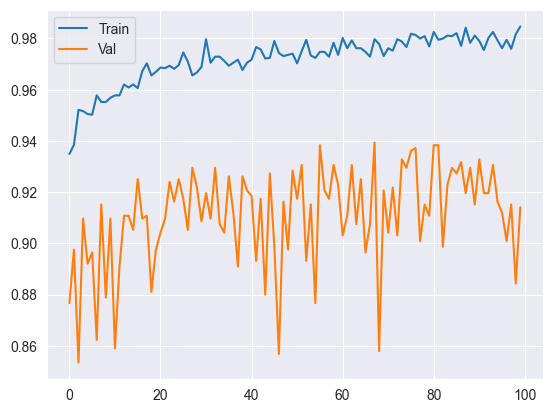

In [49]:
plt.plot(hist3.history['accuracy'], label='Train')
plt.plot(hist3.history['val_accuracy'], label='Val')
plt.legend()

plt.show()

### Matriz de confusión para ver el comportamiento del modelo

 1/29 [>.............................] - ETA: 6s

2025-06-04 23:25:15.117722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 20ms/step


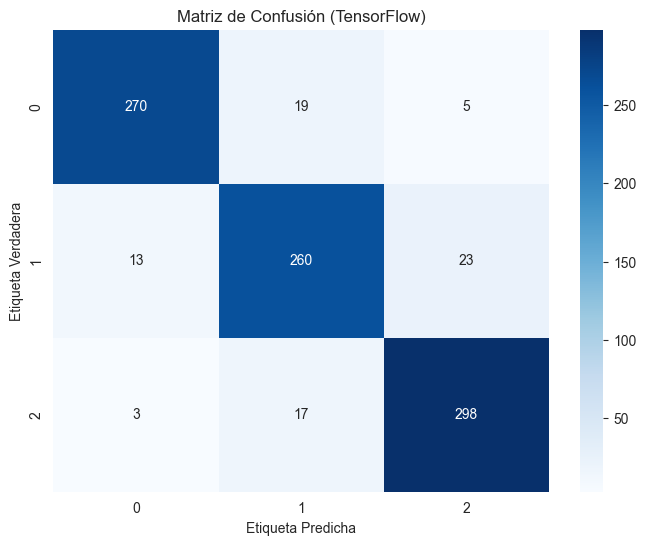

In [50]:
# 1. Obtener predicciones del modelo
y_pred_probs = model2.predict(x_test)  # Predicciones del modelo (probabilidades)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()  # Clases predichas
y_true = tf.argmax(y_test, axis=1).numpy()        # Clases reales (desde one-hot)

# 2. Calcular matriz de confusión
cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

# 3. Visualizar la matriz
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión (TensorFlow)')
plt.show()

### Refinamiento 3 inclusión de la normalización de datos

*Para intentar mejoras los resultados del modelo, estoy normalizando las imagenes*

In [51]:
# 1. Cargar dataset desde carpetas
dataset = tf.keras.utils.image_dataset_from_directory(
    directory='data/archive/Brain_Cancer raw MRI data/Brain_Cancer',
    labels='inferred',
    label_mode='categorical',
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

# 2. Convertir todo el tf.data.Dataset en arrays NumPy
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

x_data, y_data = dataset_to_numpy(dataset)

print("Total images:", x_data.shape)
print("Total labels:", y_data.shape)

# 3. Dividir manualmente en train/test (80% train, 20% test)
num_samples = x_data.shape[0]

test_size = int(num_samples * 0.15)
valid_size = int(num_samples * 0.15)
train_size = num_samples - test_size - valid_size

# Mezclar índices
indices = np.arange(num_samples)
np.random.seed(42)
np.random.shuffle(indices)

# Cortar índices para cada conjunto
test_indices = indices[:test_size]
valid_indices = indices[test_size:test_size + valid_size]
train_indices = indices[test_size + valid_size:]

# Crear splits
x_train, y_train = x_data[train_indices], y_data[train_indices]
x_valid, y_valid = x_data[valid_indices], y_data[valid_indices]
x_test, y_test = x_data[test_indices], y_data[test_indices]

# Normalizar imágenes (de [0, 255] a [0, 1])
x_train = x_train / 255.0
x_valid = x_valid / 255.0
x_test  = x_test  / 255.0

print("Train images:", x_train.shape)
print("Validation images:", x_valid.shape)
print("Test images:", x_test.shape)



Found 6056 files belonging to 3 classes.


2025-06-04 23:26:59.780637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6056]
	 [[{{node Placeholder/_4}}]]
2025-06-04 23:26:59.780966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6056]
	 [[{{node Placeholder/_4}}]]


Total images: (6056, 128, 128, 3)
Total labels: (6056, 3)
Train images: (4240, 128, 128, 3)
Validation images: (908, 128, 128, 3)
Test images: (908, 128, 128, 3)


### Refinamiento 4 Ajustes a la arquitectura inicial propuesta, reducción de capas y de complejidad

*Por los datos reduje el numero de capas y le baje la complejidad a la red convolucional dado que no tenemos tantas imagenes*

In [52]:
model = Sequential()

# Conv 1
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer), input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv 2
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Conv 3
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Clasificación
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_15 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)       

### Refinamiento 5 Implementación de Data Augmentation para mejorar los resultados del modelo

*Estoy generando mas imagenes*

In [53]:
datagen = ImageDataGenerator(rotation_range=15,
                   width_shift_range =0.1,
                   height_shift_range=0.1,
                   horizontal_flip=True,
                   vertical_flip=True)

In [54]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [55]:
checkpoint = ModelCheckpoint('Mejor_modelo.hdf5', verbose=1, save_best_only=True, monitor ='val_loss')

In [56]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [57]:
hist = model.fit(datagen.flow(x_train, y_train, batch_size=64),
          callbacks = [checkpoint],
          steps_per_epoch=x_train.shape[0]//64,
          epochs=45,
          verbose=2,
          validation_data=(x_valid, y_valid))

Epoch 1/45


2025-06-04 23:36:15.734184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-06-04 23:36:16.713434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-04 23:36:16.828388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-06-04 23:36:34.203443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 53.08552, saving model to Mejor_modelo.hdf5
66/66 - 20s - loss: 36.0489 - accuracy: 0.5086 - val_loss: 53.0855 - val_accuracy: 0.3535 - 20s/epoch - 301ms/step
Epoch 2/45

Epoch 2: val_loss did not improve from 53.08552
66/66 - 15s - loss: 14.4286 - accuracy: 0.6410 - val_loss: 56.6889 - val_accuracy: 0.3535 - 15s/epoch - 229ms/step
Epoch 3/45

Epoch 3: val_loss improved from 53.08552 to 25.92218, saving model to Mejor_modelo.hdf5
66/66 - 15s - loss: 6.8453 - accuracy: 0.6545 - val_loss: 25.9222 - val_accuracy: 0.3535 - 15s/epoch - 233ms/step
Epoch 4/45

Epoch 4: val_loss improved from 25.92218 to 17.65025, saving model to Mejor_modelo.hdf5
66/66 - 16s - loss: 4.7406 - accuracy: 0.6645 - val_loss: 17.6503 - val_accuracy: 0.3535 - 16s/epoch - 240ms/step
Epoch 5/45

Epoch 5: val_loss improved from 17.65025 to 4.35962, saving model to Mejor_modelo.hdf5
66/66 - 16s - loss: 3.9583 - accuracy: 0.6659 - val_loss: 4.3596 - val_accuracy: 0.5507 - 16s/epoch

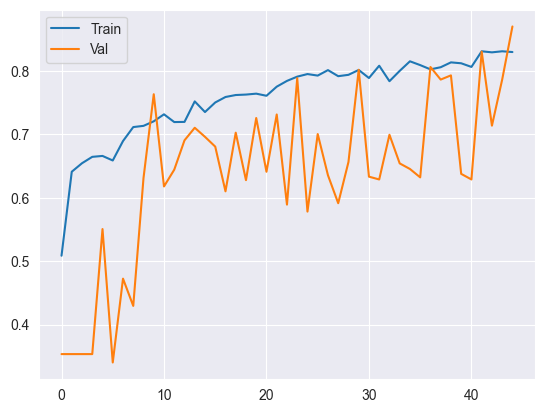

In [58]:
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Val')
plt.legend()

plt.show()

In [59]:
model2 = model
model2.load_weights('../models/Mejor_modelo.hdf5')

In [60]:
model2.evaluate(x_test, y_test)

29/29 [==============================] - 1s 37ms/step - loss: 0.6669 - accuracy: 0.9020


[0.6668830513954163, 0.9019823670387268]

## Conclusiones del modelo de clasificación 



| Iteración           | Img de resultados del modelo    | Resultados Datos                          | Conclusiones                                                                                                                                                                                                                                                             |
|---------------------|---------------------------------|-------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Modelo inicial      | ![Img1](../img/Modelo1.png)     | [1.2690447568893433, 0.9085903167724609]  | Indica que el modelo no se ajusta correctamente a los datos, en la precision se esta inclinando hacian una categoria<br/> El modelo  está sobreajustando (overfitting) desde temprano. Aprende muy bien el set de entrenamiento pero no generaliza al set de validación. |
| Refinamiento 1      | ![Img2](../img/Refinamiento1.png) | [0.28412288427352905, 0.9063876867294312] | El modelo esta aprendiendo a predecir mejor con menos error, Val empieza a seguir mejor a Train, aunque con fluctuación, Hay menos error y el modelo está mejorando su generalización.                                                                                   |
| Refinamiento 2      | ![Img3](../img/Refinamiento2.png) | [0.32337579131126404, 0.9118942618370056] | El modelo esta mas equilibrado mejoro la capacidad de clasificacion, l modelo es más estable y se nota mayor equilibrio. Sin embargo, la variabilidad en validación sugiere que aún podría mejorarse                                                                            |
| Refinamientos 3,4,5 | ![Img4](../img/Refinamiento3.png) | [0.6668830513954163, 0.9019823670387268]  | El modelo esta perdiendo ajuste el rendimiento del modelo esta decayendo                                                                                                                                                                                                 |

